# MLOps with Amazon SageMaker: Getting Started

> *This notebook works well with the `Python 3 (Data Science)` kernel on SageMaker Studio*

## Welcome

In this short workshop on MLOps with Amazon SageMaker, we'll model credit risk using SageMaker's [XGBoost Algorithm implementation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) on a customized extract of the [Statlog German Credit dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)), sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). This first notebook demonstrates connecting to the pre-loaded data in Amazon S3; preparing it and training/evaluating an initial model; while later sections will cover automation in the modelling pipeline.

This notebook is intended to be run in [Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-studio-onboard.html), assuming the [workshop CloudFormation stack](https://github.com/apac-ml-tfc/intro-to-mmlops) has been deployed.

**If you're new to Python notebooks:**

- Notebooks combine commentary (like this) and code in one interactive environment. When you first start a notebook in SageMaker Studio, you may be asked to select a **kernel** environment to run it in (see above).
- In **SageMaker Studio**, starting a new kernel may take a couple of minutes at first while a **new container (app)** is provisioned. Refer to the *Kernel starting* status at the bottom left of the screen; the *Running terminals and kernels* 'stop button' tab on the left; and your user's "Apps" list from the [SageMaker Studio Console](https://console.aws.amazon.com/sagemaker/home?#/studio/) for status... And wait until your kernel is ready before trying to run code!
- Once the kernel is ready, you can select cells (the active cell has a blue bar to the right) and then run code cells by pressing the play button (▶️) in the toolbar above or pressing `Shift+Enter`
- The status indicators in the top right (⚪️/⚫️) and bottom left (status text) of the screen show whether the kernel is busy or idle

## Contents

0. [Some extra installations](#0.-Some-extra-installations)
1. [Locating our project environment](#1.-Locating-our-project-environment)
2. [Creating a data preparation flow with SageMaker Data Wrangler](#2.-Creating-a-data-preparation-flow-with-SageMaker-Data-Wrangler)
    - [Opening Data Wrangler](#Opening-Data-Wrangler)
    - [Connecting the raw dataset](#Connecting-the-raw-dataset)
    - [Analyzing the raw data](#Analyzing-the-raw-data)
    - [Our first transform - the target column](#Our-first-transform---the-target-column)
    - [Other string-to-boolean maps](#Other-string-to-boolean-maps)
    - [Extracting ordinals](#Extracting-ordinals)
    - [More-complex-text-featurizations](#More-complex-text-featurizations)
    - [One-hot-encoding](#One-hot-encoding)
    - [Train-test split flag](#Train-test-split-flag)
    - [IF YOU RUN OUT OF TIME...](#IF-YOU-RUN-OUT-OF-TIME...)
3. [Running the data transformation job](#3.-Running-the-data-transformation-job)
4. [Extracting training/validation/test splits](#4.-Extracting-training/validation/test-splits)
5. [Training an initial model with SageMaker XGBoost Algorithm](#5.-Training-an-initial-model-with-SageMaker-XGBoost-Algorithm)
6. [Next steps](#Next-steps)

---

## 0. Some extra installations

Before we get started wih the project itself, run the cell below to install some extra libraries that will be useful for us later - but may not be present in your SageMaker notebook kernel by default:

In [8]:
!pip install altair

---

## 1. Locating our project environment

By provisioning this "project" stack from the [AWS Service Catalog](https://console.aws.amazon.com/servicecatalog/home?#products), as below...

![](imgs/01-01-service-catalog-product.png "AWS Service Catalog screenshot showing ML project product")

...You've already:

- Created a **raw data bucket** in [Amazon S3](https://s3.console.aws.amazon.com/s3/home?#) (which this notebook has *read-only* access to)
- Loaded the **raw source dataset** into the bucket
- Created a **sandbox data bucket** in Amazon S3 (which this notebook has *read-write* access to)
- Stored these important locations in the [AWS Systems Manager Parameter Store](https://console.aws.amazon.com/systems-manager/parameters/?tab=Table)

...So now we can **look up these project configuration parameters from the *project ID***, with the code below.

> **To simplify this example**, we tied the provisioning of your SMStudio user and ML project together - so your `project_id` is hard-coded to `creditmodel-USERNAME`
>
> In real-world settings the relationship between data scientists and projects is many-to-many

▶️ **Edit** the `project_id` below to match your deployed service catalog product, and then **run the cells** to look up the locations of your S3 buckets:

In [9]:
%load_ext autoreload
%autoreload 2

# The 'util' folder contains utilities we'll use throughout the workshop to keep the notebook itself tidy...
# Feel free to go and check out the implementations! What utils would you create for your own environments?
import util

project_id = "creditmodel-yudhiesh"  # TODO: Change this if you set a different Project ID in service catalog!

project_config = util.project.init(project_id)  # (Look up this project's parameters in AWS SSM)
project_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<util.project.ProjectSession(
  project_id=creditmodel-yudhiesh,
  role=arn:aws:iam::867352166187:role/DataScience/SC-867352166187-pp-7pfghfxa-SageMakerExecutionRole-P4ECNYCU9XXE,
  raw_bucket=creditmodel-yudhiesh-mlrawdata-867352166187-us-east-1,
  sandbox_bucket=creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1
) at 0x7f9cf6c692d0>

In [10]:
print(f"Raw data bucket: s3://{project_config.raw_bucket}/")
print(f"Sandbox bucket: s3://{project_config.sandbox_bucket}/")

Raw data bucket: s3://creditmodel-yudhiesh-mlrawdata-867352166187-us-east-1/
Sandbox bucket: s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/


The (read-only) `raw_bucket` contains our input data, and we'll use the `sandbox_bucket` for storing our transformations, models, evaluations, and other artifacts. You should be able to see these buckets in the [Amazon S3 Console](https://s3.console.aws.amazon.com/s3/) - with the raw data already loaded like the below:

![](imgs/01-02-raw-data-s3.png "S3 Console screenshot showing raw data file in bucket")

> ❓ How would **you** separate and control access to *your* environment's different artifacts, to foster productivity and governance?

---

## 2. Creating a data preparation flow with SageMaker Data Wrangler

This raw data is **not yet ready for modelling**.

We'll need to review and curate the features; split out training/validation/test sets; and ensure the data is in an appropriate format for using with our target algorithm. From the [SageMaker XGBoost Input/Output Interface docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost), we can see our data will need to be:

- In CSV (or Parquet) format on Amazon S3 (at least this is already satisfied)
- Having the **target column we want to predict at the front** of the dataset
- Containing **only numeric fields** - no text or etc

Rather than downloading the data and using traditional in-memory, code-based tools like Pandas in the notebook, we'll use [SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) to create a data preparation recipe or **flow**, which can be then run as job in [SageMaker Processing](https://aws.amazon.com/blogs/aws/amazon-sagemaker-processing-fully-managed-data-processing-and-model-evaluation/) on dedicated infrastructure.

### Opening Data Wrangler

In this example we've already created a blank **flow** file for you, so go ahead and open [credit-data.flow](credit-data.flow) using the folder tab to the left.

> ⏰ SageMaker Data Wrangler runs in a separate SageMaker **App**, so just like this notebook there may be a short wait while the environment initializes ready for you to use.
>
> You'll see a warning like the below for a few seconds to a few minutes:

![](imgs/01-03-data-wrangler-starting.png "Screenshot of SageMaker Studio with Data Wrangler starting up")

Once the warning message goes away, you should see a `Data Wrangler` instance & app in your *Running Terminals and Kernels* tab on the left - and a new "app" in your user's detail page on the [SageMaker Studio Console](): you're ready to get started!

![](imgs/01-04-apps-with-data-wrangler.png "Screenshot of SageMaker Console apps view for user, with Data Wrangler app ready")

### Connecting the raw dataset

▶️ **Select** "Amazon S3" and browse to *your project's* `raw_bucket` (as we retrieved in the [Locating our project environment](#1.-Locating-our-project-environment) section above).

▶️ **Select** the `german.csv` file that's been pre-populated into your bucket and (since this is a small dataset) you can **turn sampling off**.

![](imgs/01-05-select-raw-data.png "Data Wrangler screenshot with raw data file selected")

▶️ **Click** *Import dataset* to go ahead and connect the dataset once you've checked the configuration.

### Analyzing the raw data

Importing a dataset from the "Import" tab creates two nodes on your **data flow view**, which Data Wrangler uses to visualize the flow you're building:

1. The data source itself, and
2. The *inferred data types* from the CSV - which we can review and customize if needed.

In this example, the default types are fine... But before we start transforming our data we'll first add some **analyses** to understand it better.

▶️ **Click** on the `+` next to the *Data types* node and select *Add analysis* to get started

![](imgs/01-06-add-analysis.png "Data Wrangler screenshot with 'add analysis' option selected")

#### Missing Values (Custom Chart)

First, we'll use a **custom** analysis with some pre-prepared code - to analyze the proportion of missing values in the data by field.

▶️ **Create a custom chart** with the code from [charts/missing.py](charts/missing.py):

- Select the *Code* tab on the right
- Set the *Name* to `Initial Missing Values`
- Open [charts/missing.py](charts/missing.py) (from this link or the folder tab) and copy/paste in the code
- Click *Preview* and then *Create* to store your chart

![](imgs/01-07-missing-values-chart.png "Screenshot of chart showing no missing values")

Although this chart would normally show a bar chart of missing value proportions by field, the good news is that this dataset appears to have no missing values at all!

#### Quick Model (Built-In Analysis)

Let's also use one of the built-in analysis, *Quick model*:

▶️ **Create a Quick Model analysis**:

- Click the *Create new analysis* button
- Select *Quick Model* from the *Analysis type* drop-down
- Set the *Analysis name* to `Initial Quick Model`
- Set the *Label* to `credit_risk` (near the bottom of the column list)
- Click *Preview* (and, whenever you're ready, *Create*)

![](imgs/01-08-initial-quick-model.png "Bar chart of feature importances from initial quick model")

This analysis performs a simple train/test split of your model; trains a random forest model; and outputs a chart of feature importances and the overall test set accuracy metric.

While correlation analyses are still useful for identifying potentially important or redundant features; going beyond this to train a simple but non-linear model and analyse its quality of fit can take our insights to the next level during feature engineering. In this case, that the balance in the customer's checking account and the amount of the loan were highly predictive features for credit risk... While their domestic vs foreign worker status and the recorded transaction timestamp seemed essentially irrelevant.

### Our first transform - the target column

Remember how our [XGBoost Algorithm specification](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) needed numeric columns only and the target column to appear first? Let's sort that out for our first transformation:

▶️ **Click** on the *Prepare* tab in Data Wrangler to go back to the data flow view.

▶️ **Click** the `+` next to the *Data types* node and select to *Add transform* to open the transform view.

In the transform view, we see a preview of our working dataframe with options too add pre-built and custom transformations in the *TRANSFORM > Add* tab to the right. We can also switch over to the *Previous steps* tab on the right to review the steps so far on this branch of the flow:

![](imgs/01-09-add-transform-view.png "Screenshot of Data Wrangler 'add transform' view")

▶️ **Create a numeric target column**:

- Select the *Custom formula* transform section to create a custom Spark SQL transform
- Enter *Formula* `cast(credit_risk == "bad" as int)` for a numeric value
- Set *Output Column* to `credit_default` - whether the credit defaulted
- Click *Preview* and, when you're happy the new column added is correct, *Add* to add the transformation step

![](imgs/01-10-numeric-target.png "Previewing numeric credit_default column")

▶️ **Manage the target column ordering**:

- Select *Manage columns* and the default *Drop column* transform, setting the old column `credit_risk` to drop the text version
- Click *Preview*, check the right `credit_risk` column has been deleted, and then click *Add* to save the step
- Select *Manage columns* and the *Move column* transform, selecting to `Move to start` the new column `credit_default`
- Click *Preview*, check the `credit_default` column has been moved to the start of the dataframe, and then click *Add*

You should now have a numeric `credit_default` column at the start of your dataframe, and no `credit_risk` column anymore... Like this:

![](imgs/01-11-fixed-target.png "Screenshot of steps history with target column fixed to numeric at start")

If we go back to the *Prepare* tab in Data Wrangler, we'll now see a new 'stacked' set of *Steps* nodes have been added after the *Data types* configuration.

> Since the sequence of steps is linear with no branches, they're collapsed to a single node. We can use the plus button before to add new transformations, but be aware we can also insert **branches** into the flow by selecting one of the individual sub-steps - like this:

![](imgs/01-12-inserting-branches.png "Screenshot of prepare tab inserting branch transforms")

### Other string-to-boolean maps

There are two other fields in this dataset represented as strings which should be `0/1` variables instead: `telephone` and `foreign_worker`.

You can use similar `cast(XYZ == "ABC" as int)` *Custom formula* transforms to create the new numeric fields, and the *Manage columns > Drop column* transform as we did before to drop the old fields.

▶️ **Click** the `+` button after the *Steps (3)* node from the *Prepare* tab to add new transforms to the **end** of our sequence.

▶️ **Convert** the `telephone` field to `has_telephone`

▶️ **Convert** the `foreign_worker` field to `is_foreign_worker`

Your working dataframe should now look something like this:

![](imgs/01-13-numeric-telephone-foreign.png "Telephone and foreign worker fields converted to numerics")


### Extracting ordinals

The `checking_acct_status`, `savings_status`, and `highest_property` fields are all encoded as text, but with values that clearly represent **ordinal sequences**... For example `No Account / Band 1 / Band 2 / etc.`

For all of these fields the first number (if present) is the ordinal indicator, so we'll simply use a Regular Expression and fill missing values to encode the fields.

▶️ **Extract band number** in the `checking_acct_status` field:

- Use a *Search and edit > Extract using RegEx* transform with `checking_acct_status` as the input column
- Enter the *Pattern* `\d+`
- Leave the *Output column blank* to just overrride the input column
- Click *Preview* and, when you're happy the configuration is correct, *Add*.

Your `checking_acct_status` field should now be reduced to just numbers with gaps where the records were previously "No Account":

![](imgs/01-14-preview-regex-extract.png "Previewing RegEx extract transform")

Because this was a regular expression operation, the result column is typed as text even though the values are all numeric... And because customers without an account had no number in the original text; we've introduced missing values for this class.

▶️ **Convert and fill** the `checking_acct_status` field:

- Add a *Parse column as type* transform on `checking_acct_status` to convert it to `Long` type (integer)
- Add a *Handle missing > Fill missing* transform on the same column with *Fill value* `0` (again, leave the *Output column* blank to directly overwrite `checking_acct_status`)

Your `checking_acct_status` column should now be listed as a numeric type, and completely filled with no gaps, like below:

![](imgs/01-15-checking-acct-converted.png "Checking account column finished")

This field is now completed... so we just need to repeat the same process for our two other ordinal fields:

▶️ **Repeat the extract/convert/fill process** for the `savings_status` and `highest_property` fields

- You can use the same `\d+` regular expression for both fields
- The `highest_property` field actually has numbers in all entries - so you still need to do the type parsing but can skip the missing value fill!

All three fields `checking_acct_status`, `savings_status` and `highest_property` should now be converted to numerics with no gaps:

![](imgs/01-16-ordinals-done.png "Ordinal variable processing completed")

## More complex text featurizations

The `marital_status_and_gender` field is interesting, because:

- It combines two semantically separate features
- Although every record is labelled as "male" or "female", the recorded marital status options differ between the two genders.

...So we'll try to take account of this in our encoding.

▶️ **Split** the `marital_status_and_gender` field's components:

- Select a *Search and edit > Split string by delimiter* transform and select the input column
- Set the *Delimiter* to ` : ` (**WITH A SPACE BEFORE AND AFTER THE COLON!**)
- Set the *Max number of splits* to `2`
- Leave the *Output column* blank so the column is updated in-place

This creates a **vector column** (shown by the square bracket notation e.g. `[male, single]` in the preview). We can address vector columns in custom formulae, as well as splitting them out into separate columns.

▶️ **Use a custom formula** to extract a numeric `gender_is_male` field:

- Create a *Custom formula* transform with the formula: `cast(marital_status_and_gender[0] == "male" as int)`
- Set the *Output column* to `gender_is_male`

Check your new column has `1` for records where the original `marital_status_and_gender` started with `male`, and `0` where it was `female`!

Now we just need to process the marital status part of our field...

▶️ **Flatten the vectorized marital status**:

- Select a *Manage vectors > Flatten* transform to extract out columns from the vectorized `marital_status_and_gender` field
- Leave the *Output prefix* and *Vector length* settings as default. The preview should show two new columns created at the end of your dataframe: `marital_status_and_gender_0` (the gender) and `marital_status_and_gender_1` (the marital status)
- When you're comfortable the preview looks like the below, go ahead and click *Add*

![](imgs/01-17-marital-gender-split.png "Screenshot showing gender_is_male field next to split marital/gender text")

▶️ **Featurize the marital status**:

- Select the *Featurize text > Vectorize* transform
- Set *Tokenizer* to `Custom` and set the *RegEx pattern* to a simple forward slash `/` (since our marital statuses are separated by a slash)
- Keep the other *Vectorizer* settings as default, but...
- Change *Apply IDF* from the default Yes to `No`
- Select the *Input column* `marital_status_and_gender_1` (the marital status split)
- Select *Output format* `Columns` and the *Output column* to be `marital_status`
- Hit *Preview* and, when you're happy the setup matches the screenshot below, go ahead and click *Add*

This transform creates a set of columns identifying how many times (always 0 or 1 for us) each marital status appears in the record - so basically a multi-hot encoding to account for the fact that we don't always know exactly which status applies!

![](imgs/01-18-marital-status-encoding.png "Multi-hot encoded marital status")

▶️ **Clean up temporary columns**:

- Finally, use the *Manage columns > Drop column* transform to delete the three columns we no longer need: `marital_status_and_gender`, `marital_status_and_gender_0` and `marital_status_and_gender_1`

### One-hot encoding

You should now have just 4 text fields left in your dataset: `purpose`, `other_parties`, `other_installment_plans` and `housing`

All of these are fair candidates for **one-hot** encoding, since there's no obvious ordering.

▶️ **One-hot encode the target fields**:

- Select the *Categorical encoding > One-hot encode* transform type
- Change the *Output style* to `Columns` but leave other options (*Output column*, *Invalid handling strategy, etc) as the default
- Check the transform with `purpose`, and repeat for the three other fields `other_parties`, `other_installment_plans` and `housing`

In all cases the original column (e.g. `purpose`) will be deleted, and replaced with a set of new columns at the end of the dataset describing what category each record fell under (e.g. `purpose_car_new`, `purpose_repairs`, etc).

> ⚠️ **CHECK:** We're now done with engineering the input features, so your data should be fully numeric with no text fields left!

### Train-test split flag

So far we've been engineering features on our whole dataset, which of course is nice for ensuring consistency.

...But of course we'll need to segment our data into model training, validation, and test sets to explore performance. Even better if this split is:

- **Unbiased** (We don't know if there's some ordering by specific features in our core dataset)
- **Repeatable** (So we don't accidentally leak information from the test set into validation, over multiple experiments
- **Stratified** (So there's no risk of particular groups being grossly over- or under-represented in each set

In this example we'll conduct the *assignment* of this set in Data Wrangler (creating a flag column), but the *splitting* afterwards - in a realization step where train/val/test datasets are queried from our overall processed feature store. We'll do this by way of a sequence of custom Spark SQL transforms.

▶️ **Assign dataset split labels to the data**:

- Use a *Custom formula* transform:
    - Formula `random(1337)`
    - Output column `random_01`
    - ...to repeatably assign each record a random ordering value.
- Use a *Custom formula* transform:
    - Formula `row_number() over (partition by credit_default order by random_01)`
    - Output column `stratum_row_num`
    - ...to rank each record within the strata (`credit_default` target label only)
- Use a *Custom formula* transform:
    - Formula `stratum_row_num / (max(stratum_row_num) over (partition by credit_default))`
    - Output column `stratum_rank_pct`
    - ...to express each record's randomized ranking as a percentage of the stratum size
- Use a *Custom formula* transform:
    - Formula `case when (stratum_rank_pct < 0.7) then "train" when (stratum_rank_pct < 0.85) then "validation" else "test" end`
    - Output column `dataset`
    - ...to assign proportions of each stratum to the different datasets train, validation, and test

Your results should look something like the below. Don't be worried if all rows in the preview are for the `train` dataset - as the preview is only a sample of the total!

![](imgs/01-19-assigning-datasets.png "Working columns to split out datasets")

▶️ **Drop the temporary columns**:

- Finally, use *Manage columns > Drop column* transforms to drop the `random_01`, `stratum_row_num` and `stratum_rank_pct` columns which are no longer needed: Leaving just the `dataset` label.

**Our flow is finally complete!**

We've converted all our raw text fields to numbers, and added just one field `dataset` at the end of the dataframe to identify which split each record falls in.

Clicking on the *Prepare* tab, we still see only 3 nodes as there were no branches in our flow, but you should have worked up ~33 "Steps" in the transform section, if you followed along exactly!

![](imgs/01-20-completed-prep-flow.png "Prepare tab screenshot showing completed flow")

▶️ **Save** the flow file by pressing `Ctrl+S` with the `credit-data.flow` tab open!

### IF YOU RUN OUT OF TIME...

Although it's good to get hands-on with the tool, composing all these steps might take some time to get used to at first!

> ⚠️ To use your flow with the rest of this notebook, you'll need to have the `dataset` field (final section above) set up.
>
> **To use our pre-built flow with your data instead**, if you run out of time, you can:
>
> - Right click the `credit-prebuilt.flow` file and select *Open in Editor* to open the file as JSON
> - Find (near the top) the `s3Uri` that looks like `s3://DOC-EXAMPLE-BUCKET/german.csv`
> - Replace the `DOC-EXAMPLE-BUCKET` with the name of **your `sandbox_bucket`** (see earlier in this notebook)
> - Save the file
>
> In the section below, your `target_output_name` will be `e61491fa-5fc6-4761-a5f2-4175fdc3ac72.default` (the last node in the file)

---

## 3. Running the data transformation job

We've **defined** our sequence of transformation steps in the flow file (which is just JSON: try right-clicking it in the folder tab and selecting `Open in Editor`!)... So now we'd like to **run it against the full dataset**.

Data Wrangler supports **exporting** flows to either plain Python code (for running in other environments), or as **template notebooks for triggering [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) jobs**, either:

1. Directly, to output results to **Amazon S3**
2. With additional configurations output results to [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/)
3. Inside a [SageMaker Pipeline](https://aws.amazon.com/sagemaker/pipelines/)

For today's session, our environment unfortunately doesn't support SageMaker Feature Store... So we'll run option 1 (a processing job) and then go on to show SageMaker Pipelines!

Specifically we'll **show** the auto-generated notebook, but **not run it**: Instead, you'll copy out some key values and set up the job from this notebook - to demonstrate that the auto-generated code is just a guideline.

▶️ **Generate** a *Data Wrangler Job notebook*

- Click on the *Export* tab in Data Wrangler
- Select to export the final step by clicking on your *Steps* node and selecting the *final* step in the pop-up

> ⚠️ **Note:** At one point there was a UI bug where, depending on your screen and the number of steps, this pop-up could be **taller than the window** - making it impossible to select the final step!
>
> If this happens, you can **zoom out in your browser** (`Ctrl+-` or the `View` menu) until the view is big enough for the final step to be selected

- Once you've selected the final step, click the *Export step* button in the top right and select the `Data Wrangler Job` option

![](imgs/01-21-flow-export.png "Exporting the flow to a Data Wrangler Job notebook")

This will open a new "untitled.ipynb" auto-generated notebook, as below:

> ⚠️ **Note:** If you're prompted to select a kernel for the notebook, choose `Python 3 (Data Science)`

> ⚠️ **You don't need to run the contents of this notebook!** We'll just extract some key parameters and bring them back here

![](imgs/01-22-dw-job-notebook.png "Auto-generated data wrangler notebook")

> ⚠️ **You don't need to run the contents of this notebook!** We'll just extract some key parameters and bring them back here

We just need to extract two values from this notebook's **Parameters** section:

- The `container_uri` - the location & version of the Data Wrangler container image to use in the processing job
- The `output_name` - the unique ID of the flow node to be output

▶️ **Copy** these values from the auto-generated notebook to the cell below, and then run the cell:

In [11]:
container_uri = "663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:1.x"# TODO: Get from the example notebook (including the quote marks)
target_output_name = "e61491fa-5fc6-4761-a5f2-4175fdc3ac72.default" # TODO: Get from 'output_name' in the example notebook (including the quote marks)

With these and your saved flow file (which already includes the locations of input data), we have all the information needed to run the flow as a SageMaker Processing job to create the result files in S3.

First, the cell below will connect to the SageMaker APIs in this region:

In [12]:
import sagemaker  # High-level Python SDK for Amazon SageMaker
smsess = sagemaker.Session()
region = smsess.boto_region_name
print(region)

us-east-1


...Then in the next two cells, we'll use some more `util` functions (similar to the code in the auto-generated notebook) to define and run the processing job.

In [13]:
processor = sagemaker.Processor(
    role=sagemaker.get_execution_role(),  # Just use the same permissions as the current notebook's IAM role
    image_uri=container_uri,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
)

In [16]:
# We'll create a unique name each time the job is run:
processing_job_name = util.uid.append_timestamp("credit-flow")
print(f"Creating Processing job with name {processing_job_name}")

# ...And transparently the flow file to S3 as required for the processing job input:
flow_upload_s3uri = f"s3://{project_config.sandbox_bucket}/data-wrangler/{processing_job_name}/flow/credit-data.flow"
print(f"Uploading flow file to {flow_upload_s3uri}")

# Processing outputs automatically create jobname/outputnames subfolders:
base_output_s3uri = f"s3://{project_config.sandbox_bucket}/data-wrangler"
print(f"Storing results to {base_output_s3uri}")

processor.run(
    # TODO: Change here to the "credit-data.flow" if using your own flow instead!
    inputs=util.wrangler.create_processing_inputs("credit-prebuilt.flow", flow_upload_s3uri),
    # ^^^
    outputs=[
        util.wrangler.create_s3_output(target_output_name, base_output_s3uri),
#         # Alternative for a feature store job:
#         util.wrangler.create_featurestore_output(
#             target_output_name,
#             feature_group_name,
#         )
    ],
    arguments=util.wrangler.create_container_arguments(target_output_name),
    wait=True,
    #logs=False,
    job_name=processing_job_name,
)

Creating Processing job with name credit-flow-2021-03-25-08-14-10
Uploading flow file to s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/data-wrangler/credit-flow-2021-03-25-08-14-10/flow/credit-data.flow
Storing results to s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/data-wrangler
Uploaded credit-prebuilt.flow to s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/data-wrangler/credit-flow-2021-03-25-08-14-10/flow/credit-data.flow

Job Name:  credit-flow-2021-03-25-08-14-10
Inputs:  [{'InputName': 'flow', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/data-wrangler/credit-flow-2021-03-25-08-14-10/flow/credit-data.flow', 'LocalPath': '/opt/ml/processing/flow', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'german.csv', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://creditmodel-yudhiesh-mlrawdata-867352166187

When our processing job completes successfully, the result data will be stored in Amazon S3.

We can list the contents of the output folder, read it into a Pandas DataFrame here on the notebook, and even go check the data is visible in the [Amazon S3 Console](https://s3.console.aws.amazon.com/s3/)

In [17]:
flow_output_s3uri = f"{base_output_s3uri}/{processing_job_name}/{target_output_name.replace('.', '/')}/"
print(flow_output_s3uri)
!aws s3 ls $flow_output_s3uri

s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/
2021-03-25 08:19:07        852 part-00000-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
2021-03-25 08:19:07      47830 part-00001-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
2021-03-25 08:19:07     110396 part-00003-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv


In [18]:
df = util.data.dataframe_from_s3_folder(flow_output_s3uri)
df.head()

Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00000-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00001-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00003-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv


,credit_default,txn_id,txn_timestamp,checking_acct_status,duration_months,credit_history,credit_amount,savings_status,present_employment_yrs_lt,installment_rate_disp_income_pct,...,other_parties_none,other_parties_guarantor,other_parties_coapplicant,other_installment_plans_none,other_installment_plans_bank,other_installment_plans_stores,housing_own,housing_rent,housing_for_free,dataset
0,1,54,1616653095,2,36,3,2225,1,10,4,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,train
1,1,835,1616653095,1,12,0,1082,1,4,4,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,train
2,1,192,1616653095,2,27,2,3915,1,4,4,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,train
3,1,175,1616653095,0,30,1,7485,0,0,4,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,train
4,1,335,1616653095,1,6,4,3384,1,4,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,train


> ⚠️ **Check:** the data snapshot above looks OK!

Since this dataset is small enough to load in Pandas, we can also perform some diagnostics here to check that our dataset was split correctly:

In [19]:
# Check dataset split is OK:
dataset_lens = df.groupby(["dataset"])["credit_default"].count()
dataset_lens / len(df)

dataset
test          0.152
train         0.698
validation    0.150
Name: credit_default, dtype: float64

...That the stratification distributed samples as we hoped:

In [20]:
# Check stratification has worked:
df.groupby(["dataset", "credit_default"])["credit_default"].count() / dataset_lens

dataset     credit_default
test        0                 0.697368
            1                 0.302632
train       0                 0.700573
            1                 0.299427
validation  0                 0.700000
            1                 0.300000
Name: credit_default, dtype: float64

...Or even whether there are any obvious problems with the distribution of non-stratified fields after the split:

In [21]:
# How about the distribution of non-stratified fields:
df.groupby(["dataset", "gender_is_male"])["gender_is_male"].count() / dataset_lens

dataset     gender_is_male
test        0                 0.328947
            1                 0.671053
train       0                 0.312321
            1                 0.687679
validation  0                 0.280000
            1                 0.720000
dtype: float64

Assuming all looks well, we're ready to move on to the next stage and start feeding our data into models!

---

## 4. Extracting training/validation/test splits

In a real-world use-case, it may be useful to store these features in a repository like [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/) to foster their discovery and re-use within our organization - rather than just as plain data in S3.

We would then *query* this feature store to *realise* snapshots of the data for model training, validation, and test: And in the case of SageMaker Feature Store be able to use features like time travel to trace back changes between record versions.

Since our environment for today's session doesn't support this feature, we'll **emulate** the idea using our existing data export and local `util` code as a feature store stand-in. The cell below will query the base export from data wrangler by the `dataset` column, to create separate folders in S3 for each dataset:

In [22]:
# Emulate SageMaker Feature Store since we're not able to use it here:
model_datasets_s3uri = f"s3://{project_config.sandbox_bucket}/model-datasets"

model_datasets = util.data.mock_featurestore_dataset_split(
    flow_output_s3uri,
    model_datasets_s3uri,
    dataset_label_col="dataset",
    datasets_with_headers=r"train.*",  # Only include headers on the 'train' set
    drop_cols=["txn_id", "txn_timestamp"],  # Feature store internal columns, not for modelling
)

print(f"\nSplit datasets out to:")
model_datasets

Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00000-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00001-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv
Loading data-wrangler/credit-flow-2021-03-25-08-14-10/e61491fa-5fc6-4761-a5f2-4175fdc3ac72/default/part-00003-4bb2c456-9acf-4906-8b41-fcb1da1d9abc-c000.csv

Split datasets out to:


{'train': ['s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/model-datasets/train/part0.csv'],
 'validation': ['s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/model-datasets/validation/part0.csv'],
 'test': ['s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/model-datasets/test/part0.csv']}

---

## 5. Training an initial model with SageMaker XGBoost Algorithm

In SageMaker, *algorithms* (whether built-in or custom) are defined by **container images**... So we'll first need to look up the URI of the SageMaker XGBoost container of the version we'd like to use:

In [23]:
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.0-1")
print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


...then set up our inputs - training and validation format prepared on S3 in a compatible format for the algorithm:

In [24]:
train_uri = f"{model_datasets_s3uri}/train"
print(f"Training data: {train_uri}")
s3_input_train = sagemaker.inputs.TrainingInput(train_uri, content_type="csv")

val_uri = f"{model_datasets_s3uri}/validation"
print(f"Validation data: {val_uri}")
s3_input_validation = sagemaker.inputs.TrainingInput(val_uri, content_type="csv")

Training data: s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/model-datasets/train
Validation data: s3://creditmodel-yudhiesh-mlsandbox-867352166187-us-east-1/model-datasets/validation


...and finally, actually create the training job using the high-level [Estimator API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

The `Estimator` class provides a familiar, scikit-learn-like API for `fit()`ting models to data, `deploy()`ing models to real-time endpoints, or running batch inference jobs.

In [25]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type="ml.m5.xlarge",  # type of training instance
    instance_count=1,  # number of instances to be used
    role=sagemaker.get_execution_role(),  # Just use the current notebook's IAM role
    max_run=20*60,  # Maximum allowed active runtime
    base_job_name=f"{project_id}-xgboost",
    output_folder=f"s3://{project_config.sandbox_bucket}/model-training",  # TODO: Maybe not respecting this?
#     use_spot_instances=True,  # Use spot instances to reduce cost
#     max_wait=30*60,  # Maximum clock time (including spot delays)
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150,  # int: [1,300]
    max_depth=5,  # int: [1,10]
    alpha=2.5,  # float: [0,5]
    eta=0.5,  # float: [0,1]
    objective="binary:logistic",
)

# start a training (fitting) job
estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })

2021-03-25 08:21:18 Starting - Starting the training job...
2021-03-25 08:21:22 Starting - Launching requested ML instancesProfilerReport-1616660478: InProgress
.........
2021-03-25 08:23:06 Starting - Preparing the instances for training...
2021-03-25 08:23:49 Downloading - Downloading input data
2021-03-25 08:23:49 Training - Downloading the training image...
2021-03-25 08:24:15 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[08:24:17] 699x40 matrix with

The cell above will wait until the training job completes, and pull through logs from the job as it runs. You can also see additional information on the [Training jobs page of the SageMaker Console](https:/console.aws.amazon.com/sagemaker/home?#/jobs): Such infrastructure usage and algorithm metrics; and the parameters of the job.

---

## 6. Testing the model with SageMaker Batch Transform

While the training job itself produced error/accuracy metrics on the training and validation datasets; it's often beneficial to *evaluate* the trained model against some test dataset to see detailed results and drill in to performance.

Below, we run a [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) job using our trained model against the `test` dataset we created earlier and kept away from the training job.

Because Batch Transform supports all kinds of models (not just tabular data, but e.g. computer vision or text too), there are additional configuration options for controlling how it feeds data into our model and consolidates result files:

In [26]:
test_data_uri = f"{model_datasets_s3uri}/test"
test_output_uri = f"s3://{project_config.sandbox_bucket}/model-eval/{estimator.latest_training_job.name}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=test_output_uri,
    accept="text/csv",  # XGBoost algorithm supports multiple response formats - we want CSV
    assemble_with="Line",  # Consolidate inference responses as a single file, newline-separated (like a CSV)
)

transformer.transform(
    data=test_data_uri,
    data_type="S3Prefix",
    content_type="text/csv",  # XGBoost algorithm supports multiple input formats - we have CSV
    split_type="Line",  # Batch Transform can split large input files into batches - on any newline is fine
    join_source="Input",  # Add the input columns in to the output file (easier accuracy reconciliation!)
    input_filter="$[1:]",  # Don't send the first (ground truth) column in to the model!
)

.............................[2021-03-25:08:29:38:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-25:08:29:38:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-25:08:29:38:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-03-25:08:29:38:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-25:08:29:38:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-25:08:29:38:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|in

When the batch transform job has completed successfully, our result files will be available in S3 at the output location:

In [27]:
!aws s3 ls --recursive $test_output_uri

2021-03-25 08:29:44      23505 model-eval/creditmodel-yudhiesh-xgboost-2021-03-25-08-21-17-854/part0.csv.out


We can read this data in to our notebook as before - but need to set up the column names manually since the file itself doesn't have a header:

In [28]:
test_result_colnames = list(
    filter(lambda c: c not in {"dataset", "txn_id", "txn_timestamp"}, df.columns.tolist())
) + ["credit_default_pred"]

test_result_df = util.data.dataframe_from_s3_folder(test_output_uri, header=None, names=test_result_colnames)
test_result_df.head()

Loading model-eval/creditmodel-yudhiesh-xgboost-2021-03-25-08-21-17-854/part0.csv.out


,credit_default,checking_acct_status,duration_months,credit_history,credit_amount,savings_status,present_employment_yrs_lt,installment_rate_disp_income_pct,present_residence_since,highest_property,...,other_parties_none,other_parties_guarantor,other_parties_coapplicant,other_installment_plans_none,other_installment_plans_bank,other_installment_plans_stores,housing_own,housing_rent,housing_for_free,credit_default_pred
0,1,1,12,2,674,2,7,4,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.222375
1,1,0,18,3,1808,1,7,4,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.023244
2,1,2,48,4,5096,1,4,2,3,3,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.418617
3,1,3,12,4,939,3,7,4,2,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.151963
4,1,1,48,0,4605,1,10,3,4,4,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.699565


Finally, we can compare the model score in the final column `credit_default_pred` with the ground truth value in the first column `credit_default` - by whatever our preferred metrics are for analyzing the result.

The cell below will create a classification model summary report from the two columns, including a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), a [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), and some other summary statistics.

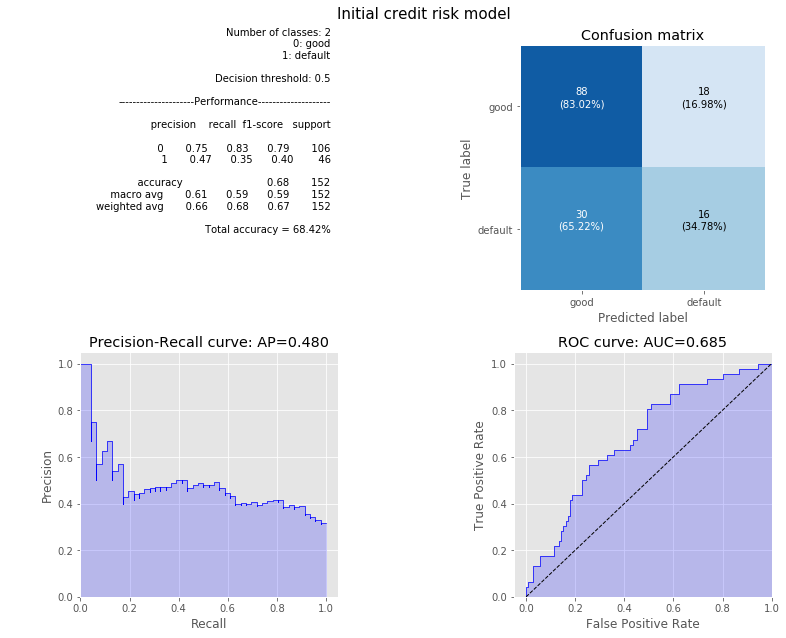

In [29]:
util.plotting.generate_classification_report(
    y_real=test_result_df["credit_default"],
    y_predict_proba=test_result_df["credit_default_pred"],
    decision_threshold=0.5,
    class_names_list=["good", "default"],
    title="Initial credit risk model",
)

In our original test, this initial model achieved an AUC of around 0.685; with a final validation error (in the training job) of 0.24000... Plenty of room for improvement with better feature engineering and hyperparameter tuning!

## Next steps

In this notebook we:

- Used SageMaker Data Wrangler to **analyze and featurize** raw data from our project's `raw_bucket`
- **Ran our Data Wrangler flow** as a SageMaker Processing Job, to output featurized data to our project `sandbox_bucket` (although we might have used SageMaker Feature Store as our repository instead)
- **Queried** this main feature store to realise our individual `train`, `validation` and `test` datasets in S3
- **Trained** a first model with SageMaker's first-party XGBoost Algorithm implementation
- **Evaluated** the model's predictions on our `test` dataset

Next, we'll consider ways to automate workflows for model (re)-training, evaluation, approval, deployment, and monitoring - introducing [Amazon SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/)!